<a href="https://colab.research.google.com/github/afiaka87/clip-guided-diffusion/blob/main/cgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Guided Diffusion 

**From [RiversHaveWings](https://twitter.com/RiversHaveWing)**

Generate vibrant and detailed images using only text.
- Originally by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). 
- Python repository and additions assembled by Clay Mullis (https://github.com/afiaka87)

**[Read Me](https://github.com/afiaka87/clip-guided-diffusion)**

In [ ]:
#@title Licensed under the MIT License

# Copyright (c) 2021 Clay Mullis, Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [ ]:
#@title Grab code and install requirements
# colab only
%cd /content
!git clone 'https://github.com/afiaka87/clip-guided-diffusion'
!git clone 'https://github.com/afiaka87/guided-diffusion'
%pip install -r /content/clip-guided-diffusion/requirements.txt 
%pip install -e guided-diffusion

In [1]:
#@title Config
#@markdown Detailed usage instructions are at the bottom of the notebook.

#@markdown Text Prompts
prompt = "alien friend by Odilon Redo" #@param{type: "string"}
prompt_min = "" #@param{type: "string"}
min_weight = 0.1 #@param{type: "number"}

#@markdown CLIP/Diffusion
image_size = "128"  #@param ["64", "128", "256", "512"]
image_size = int(image_size)
unconditional = False #@param{type: "boolean"}
clip_model_name = "ViT-B/32" #@param ["RN50", "ViT-B/32", "ViT-B/16", "RN50x4", "RN50x16"]

#@markdown Initial image (url or path, set to "" to disable)
init_image = "" #@param{type: "string"}
skip_timesteps = 0 #@param{type: "number"}
if len(init_image) > 0 and skip_timesteps == 0:
    print("Overriding skip_timesteps to 500 because init_image is set but skip_timesteps is 0. You may want to override this manually.")
    skip_timesteps = 500
if len(init_image) == 0:
    if skip_timesteps > 0:
        print("Overriding skip_timesteps to 0 because you dont have an init image set.")
        skip_timesteps = 0

#@markdown Knobs
num_cutouts = 64 #@param{type: "number"}
timestep_respacing = "250" #@param ["25", "50", "100", "250", "500", "1000", "ddim25", "ddim50", "ddim100", "ddim250", "ddim500", "ddim1000"]
clip_guidance_scale = 1000 #@param{type: "number"}
tv_scale = 100 #@param{type: "number"}
cutout_power = 0.5 #@param {type: "number"}
cutout_power = float(cutout_power)
fp32_diffusion = False #@param{type: "boolean"}
dropout = 0.1 if image_size == 64 else 0.0


#@markdown Use CLIP to find ImageNet classes (consider lowering clip guidance scale to avoid artifacts/noise)
class_score = False #@param{type: "boolean"}
top_n = 1000

#@markdown Output
save_frequency = 1 #@param{type: "number"}

#@markdown "diffusion_steps" schedule of timesteps over which to run diffusion. Values other than 1000 can lead to NaN errors.
diffusion_steps = 1000 #@param {type: "number"}

batch_size = 1 #@param{type: "number"}

random_affine = False #@param{type: "boolean"}
random_motion_blur = False #@param{type: "boolean"}
random_horizontal_flip = False #@param{type: "boolean"}

seed = 0 #@param {type: "number"}

# probably don't touch
noise_schedule = "cosine" if image_size == 64 else "linear"
output_dir = "outputs"
augs = []
import kornia.augmentation as kaugs
if random_affine: augs.append(kaugs.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1))
if random_motion_blur: augs.append(kaugs.RandomMotionBlur(kernel_size=(3, 5), angle=15, direction=0.5))
if random_horizontal_flip: augs.append(kaugs.RandomHorizontalFlip(p=0.5))

total_steps = int(timestep_respacing.replace("ddim","")) - skip_timesteps

# Load init image.
if len(init_image) > 0:
    if init_image.startswith("http"):
        !wget --continue $init_image -O init_image.jpg
    else:
        !cp -n -v $init_image init_image.jpg
    init_image = "init_image.jpg"
_class_cond = not unconditional

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Run

In [2]:
#@title Initialize CLIP Guided Diffusion and Progress Bar
import sys
import pathlib
from IPython.display import Image as ipy_Image
from IPython.display import display as ipy_display
from IPython.display import clear_output as ipy_clear_output
from tqdm.autonotebook import tqdm
import torch as th

from IPython.display import HTML
import base64

def show_gif(fname):
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return HTML(f'<img src="data:image/gif;base64,{b64}" />')

# thanks @nshepperd!
def refresh_cuda_memory():
    import gc
    gc.collect()
    for obj in gc.get_objects():
        if not isinstance(obj, th.Tensor):
            continue
        if isinstance(obj, th.nn.Parameter):
            obj.grad = None
            continue

        obj.data = obj.data.cpu()
    gc.collect()
    th.cuda.empty_cache()
refresh_cuda_memory()

pathlib.Path("outputs").mkdir(exist_ok=True)
total_steps = int(timestep_respacing.replace("ddim","")) - skip_timesteps
progress_bar = tqdm(total=total_steps, unit="steps")

/home/samsepiol/Projects/clip-guided-diffusion/cgd_venv/lib/python3.9/site-packages/torch/distributed/distributed_c10d.py:151: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


  0%|          | 0/250 [00:00<?, ?steps/s]

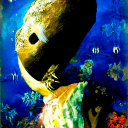

In [3]:
#@title Start diffusion
from PIL import Image as pil_Image

clear_scrollback = True # @param {type:"boolean"}
display_width = "256" #@param {type:"string"}
if len(display_width) > 0:
    display_width = int(display_width)
else:
    display_width = 256 if image_size < 512 else 512

refresh_cuda_memory()
sys.path.append("clip-guided-diffusion")
sys.path.append("guided-diffusion")
from cgd.cgd import clip_guided_diffusion
cgd_samples = clip_guided_diffusion(
    prompt=prompt,
    prompt_min=prompt_min,
    min_weight=min_weight,
    batch_size=batch_size,
    tv_scale=tv_scale,
    top_n=top_n,
    image_size=image_size,
    class_cond=_class_cond,
    clip_guidance_scale=clip_guidance_scale,
    cutout_power=cutout_power,
    num_cutouts=num_cutouts,
    timestep_respacing=timestep_respacing,
    seed=seed,
    diffusion_steps=diffusion_steps,
    skip_timesteps=skip_timesteps,
    init_image=init_image,
    clip_model_name=clip_model_name,
    class_score=class_score,
    randomize_class=(_class_cond),
    fp32_diffusion=fp32_diffusion,
    noise_schedule=noise_schedule,
    dropout=dropout,
    augs=augs
)
all_generations = []
for step, output_path in enumerate(cgd_samples):
    progress_bar.update(save_frequency)
    ipy_clear_output(clear_scrollback)
    all_generations.append(output_path)
    progress_bar.set_description(f"Saving image {step} to {output_path}")
    ipy_display(ipy_Image(output_path, width=display_width))


refresh_cuda_memory()


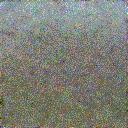

In [7]:
#@title (WIP) All generations as a GIF
# so long as you dont run any other cells; you may re-run this one to change the gif length
#@markdown `frame_duration_in_ms` how long each frame is displayed for in milliseconds. lower = shorter, higher = longer
frame_duration_in_ms = 50 #@param {type:"number"}
gif_img, *imgs = [pil_Image.open(f) for f in sorted(all_generations)]
gif_img.save(fp='run.gif', format='GIF', append_images=imgs, save_all=True, duration=frame_duration_in_ms, loop=0)
show_gif("run.gif")

# Usage
- `prompt` - the text to be used for generating the image.
- `prompt_min` - (optional) - text you would like to penalize during generation.
- `clip_guidance_scale` - CLIP based loss scale. **Requires experimentation to find the best value. 100-500 seems to work well with class_search, 500-2000 for more abstract prompts.**
- `tv_scale` - Denoising loss scale. **Requires experimentation to find the best value. 0-250 seems to work well.**
- `class_score` Rank classes with CLIP instead of uniform random selection
- `top_n` max classes to rank.
- `timestep_respacing` - Number of timesteps to visit out of total `diffusion_steps`.
- `timestep_respacing` must be one of `["25", "50", "100", "250", "500", "1000", "ddim25", "ddim50", "ddim100", "ddim250", "ddim500", "ddim1000"]`
    - Smaller values are much faster but less accurate.
    - Larger values are very accurate but take much longer.
- `init_image` - Sample image for `skip_timsteps` before guiding with CLIP.
- `skip_timesteps` should be less than `timestep_respacing` and `diffusion_steps`
- `num_cutouts` can be increased to increase the number of random cutouts CLIP sees. Higher is more accurate but takes longer.
- `cutout_power` can be decreased to 0.5 with sufficiently high num_cutouts.
- `num_cutouts` makes much less of a difference with guided diffusion. 8 seems to be a good minimum and beyond 64 seems to have diminishing returns.
- disabling `class_cond` will also disable class randomization/clip scoring
- I have not experimented with transforms much; these are merely here to showcase how to use them.**

VRAM/Runtime for `clip_model=ViT-B/32`, `cutn=32`, `timestep_respacing=250`, GPU: RTX 2070 Super (8GB)
- 64x64 - **3402 MB, 46.4s**
- 128x128 - **3524 MB, 67.9s**
- 256x256 - **7149 MB, 159.1s**
- 512x512 - **Untested (requires more than 8 GB of VRAM)**